In [30]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List
import tsplib95
import numpy as np
import math
import matplotlib.pyplot as plt


In [31]:


def calculate_distance_matrix(values, calculate):
    size = len(values)
    matrix = np.zeros((size,size), dtype=np.uint32)
    
    for i, start in enumerate(values):
        #if i > 10:
        #    break
        for j, end in enumerate(values):
            #if j > 10:
            #    break
            matrix[i,j] = calculate(start, end, round=math.ceil)
    
    for i in range(size):
        matrix[i,i] = 2**32 -1
        
    return matrix



def plot_result(graph_cord, solution, filename=None, title="Title"):
    
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize = (8,8))
    plt.title(title, fontdict=font)    
    X = []
    Y = []
    labels = []
    
    for x, y, label in solution:
        X.append(x)
        Y.append(y)
        labels.append(label)
    

    ALL_Y = [node[1] for node in graph_cord]       
    ALL_X = [node[0] for node in graph_cord]

    #all cities  
    plt.scatter(ALL_X, ALL_Y)
    
    #solution path
    plt.plot(X, Y,"or-")
   
    #print labels
    for i in range(len(solution)):
        plt.text(X[i], Y[i], labels[i], fontsize=15)
    
    if filename:
        plt.savefig(filename)

    plt.show()

In [32]:

class Cycle():
    def __init__(self, vertex_list, length):
        self._vertex_list = vertex_list
        self._length = length
        
    @property
    def cycle(self):
        return self._vertex_list
    
    @property
    def length(self):
        return self._length
    
    def __str__(self):
        return f"({self._length}, {self._vertex_list})\n"
    
    def __repr__(self):
        return f"({self._length}, {self._vertex_list})\n"

In [33]:

class Instance():
    def __init__(self, strategy: Strategy, description="") -> None:
        self._strategy = strategy
        self._coordinates = []
        self._labels = []
        self._solutions = []
        self._description = description
        self._distance_matrix = None
    
    
    @property
    def description(self):
        return self._description
    
    @description.setter
    def description(self, description):
        self._description = description
    
    @property
    def strategy(self) -> Strategy:
        return self._strategy
    
    @strategy.setter
    def strategy(self, strategy: Strategy) -> None:
        self._strategy = strategy
        
    @property 
    def solutions(self):
        return self._solutions
    
    @property 
    def distance_matrix(self):
        return self._distance_matrix
    
    @property 
    def labels(self):
        return self._labels
    
    @property 
    def coordinates(self):
        return self._coordinates
    
    def load_problem(self, filename):
        problem = tsplib95.load(filename)
        coord   = problem.as_name_dict().get('node_coords')
        self._labels       = list(coord.keys())
        self._coordinates  = list(coord.values())
        self._distance_matrix = calculate_distance_matrix(self._coordinates, tsplib95.distances.euclidean)
    

    def run(self, num_of_iterations=50, num_of_nodes=50) -> None:
        self._solutions = []
        for i in random.sample(range(0, len(self._coordinates)), num_of_iterations):
            result = self._strategy.do_algorithm(self._distance_matrix, i, num_of_nodes)    
            self._solutions.append(result)
            
        self._solutions = sorted(self._solutions, key=lambda solution: solution.length) 
        
    def get_min(self):
        return self._solutions[0].length
    
    def get_max(self):
        return self._solutions[-1].length
    
    def get_avg(self):
        return sum(solution.length for solution in self._solutions)/len(self._solutions)

    
    def save_to_file(self, filename=None):    
        solution_to_print = []
        for i in self._solutions[0].cycle:
            solution_to_print.append((*self._coordinates[i], str(self._labels[i])))
        
        title = self._description + ", "if self._description else ""
        title += "distance: " + str(self._solutions[0].length)
   
        plot_result(self._coordinates, solution_to_print, filename=filename, title=title)
        
    def show_stats(self):
        cycle_labels = []
        for i in self._solutions[0].cycle:
            cycle_labels.append(str(self._labels[i]))
            
        print(f"MIN:{self.get_min()}")
        print(f"MAX:{self.get_max()}")
        print(f"AVG:{self.get_avg()}")
        
        print("Cycle:")
        print(cycle_labels)

    
    


In [34]:
class Strategy(ABC):
    @abstractmethod
    def do_algorithm(self, matrix=None, startPoint=0):
        pass
    
    


In [96]:
import random

class RandomStrategy(Strategy):
    def do_algorithm(self, matrix=None, startPoint=0):
        vert_list = np.random.randint(0,100, 10)
        vert_list = np.append(vert_list, vert_list[0])
        
        return Cycle(vert_list, random.randint(0,1000))
    
class NNStrategy(Strategy):
    def do_algorithm(self, matrix, startPoint=0, stop=50):
        dist_matrix = matrix.copy()
        
        size, _ = dist_matrix.shape
        tour = []
        distance = 0
        
        i = startPoint
        tour.append(i)
        dist_matrix[:,i] = 2**32 -1
        
        
        
        while len(tour) != stop and len(tour) < size:
            j = np.argmin(dist_matrix[i,:])
            tour.append(j)
            distance += matrix[i,j]
            dist_matrix[:,j] = 2**32 -1
            dist_matrix[j,i] = 2**32 -1
            i = j

        distance += matrix[tour[0],tour[-1]]
        tour.append(tour[0])
      
        
        return Cycle(tour, distance)

    

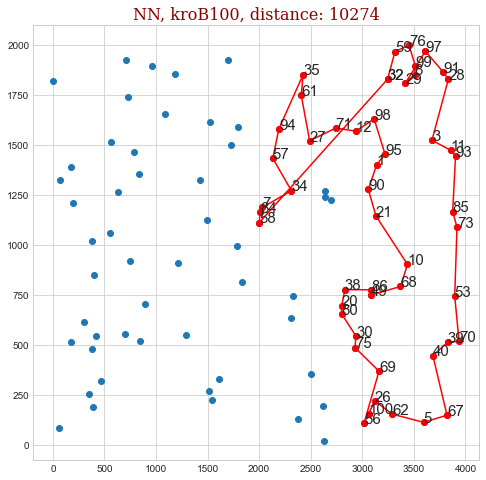

MIN:10274
MAX:15767
AVG:13311.58
Cycle:
['32', '59', '76', '99', '8', '29', '97', '91', '28', '3', '11', '93', '85', '73', '53', '70', '39', '40', '67', '5', '62', '26', '100', '56', '69', '75', '30', '80', '20', '38', '86', '49', '68', '10', '21', '90', '1', '95', '98', '12', '71', '27', '61', '35', '94', '57', '34', '7', '84', '58', '32']


In [98]:
instance  = Instance(NNStrategy())
instance.load_problem("data/kroB100.tsp")
instance.description = "NN, kroB100"
instance.run(50, 50)
instance.save_to_file("results/NN_kroB100.png")
instance.show_stats()

#instance  = Instance(NNStrategy())
#instance.run()


#instance.strategy = GreedyCycleStrategy()
#instance.run()

In [28]:
randomlist = random.sample(range(0, 100), 50)


def closest_neighbor(self, tour, node, in_tour=False, farthest=False):
        neighbors = self.distances[node]
        current_dist = [(c, d) for c, d in neighbors.items()
                        if (c in tour if in_tour else c not in tour)]
        return sorted(current_dist, key=itemgetter(1))[-farthest]
    
def add_closest_to_tour(self, tour):
        best_dist, new_tour = float('inf'), None
        for city in self.cities:
            if city in tour:
                continue
            for index in range(len(tour) - 1):
                dist = self.add(tour[index], tour[index + 1], city)
                if dist < best_dist:
                    best_dist = dist
                    new_tour = tour[:index + 1] + [city] + tour[index + 1:]
        return best_dist, new_tour

        # add node k between node i and node j
    def add(self, i, j, k):
        return self.distances[i][k] + self.distances[k][j] - self.distances[i][j]

In [44]:
from operator import itemgetter 

in_tour = False
tour = [1]
neighbors = [(1,0), (2, 20), (3, 11), (4,33), (5,6)]
curent_dist = [(c,d) for c, d in neighbors if ( c in tour if in_tour else c not in tour)]
print(sorted(curent_dist, key=itemgetter(1))[-True])

(4, 33)


In [92]:
"""
    0 - Poznan
    1 - Swarzedz
    2 - Buk
    3 - leszno
    4 - wrzesnia
    5 - gniezno    
"""

d = np.array([[0,  12, 36,  82,  52,  50], 
              [12,  0, 48,  94,  36,  44], 
              [36, 48,  0,  72,  78,  89], 
              [82, 94, 72,   0, 122, 132],
              [52, 36, 78, 122,   0,  25], 
              [50, 44, 89, 132,  25,   0]] )
print (d)

class Insertion:
    def __init__(self, city_id, position_in_solution, cost):
        self.city_id = city_id
        self.position_in_solution = position_in_solution
        self.cost = cost

    def __str__(self):
        return f'Insertion(City {self.city_id}, In {self.position_in_solution}, Cost {self.cost})'

    def __repr__(self):
        return self.__str__()

    
def _insertion_cost(d, i, j, k) -> int:
    cost_before =  d[i, j]
    cost_after  =  d[i, k] + d[k, j]
    cost_insertion = cost_after - cost_before
    return cost_insertion
    


    def _map_insertions_on_insertion_costs(self, city_insertions: defaultdict) -> list:
        """
        For each city aggregate its insertions based on regret and choose the best one
        :param city_insertions: 'city_id': [insertion(city_id,position,cost), insertion ...]
        :return: List of insertions
        """
        result = list()
        for city_id, insertions in city_insertions.items():
            sorted_insertions = sorted(insertions, key=attrgetter('cost', 'city_id'))
            cheapest_insertion = sorted_insertions[0]
            changed_insertion = deepcopy(cheapest_insertion)

            if self.regret != 0 and len(insertions) >= 2:
                for i in range(1, 1 + self.regret):
                    changed_insertion.cost += cheapest_insertion.cost - sorted_insertions[i].cost
                changed_insertion.cost *= -1  # dirty hack to avoid checking if there is regret or no during
                # choosing best insertion

            result.append(changed_insertion)
        return result


from collections import defaultdict
city_insertion = defaultdict(list)

for city_id in cities_to_check:
    for i, val in enumerate(zip(tour, tour[1:])):
        insertion = Insertion(city_id, i + 1, _insertion_cost(d, *val, city_id))
        city_insertion[str(city_id)].append(insertion)
        



#while len(set(tour)) < 2:

l = [0, 1, 2, 3, 4, 5]
tour = [0,1,2, 0]

cities_to_check = list(set(list(l)) - set(tour))
city_insertions = defaultdict(list)
    
for city_id in cities_to_check:
    for i, pair in enumerate(zip(tour, tour[1:])):
        insertion: Insertion = Insertion(city_id, i + 1, _insertion_cost(d, *pair, city_id))
        city_insertions[str(city_id)].append(insertion)

        #city_insertion_cost = self._map_insertions_on_insertion_costs(city_insertions)

        #best_city_insertion: Insertion = min(city_insertion_cost, key=lambda x: x.cost)  # min cost
        #tour.insert(best_city_insertion.position_in_solution, best_city_insertion.city_id)
    
print (city_insertion)

[[  0  12  36  82  52  50]
 [ 12   0  48  94  36  44]
 [ 36  48   0  72  78  89]
 [ 82  94  72   0 122 132]
 [ 52  36  78 122   0  25]
 [ 50  44  89 132  25   0]]
defaultdict(<class 'list'>, {'3': [Insertion(City 3, In 1, Cost 164), Insertion(City 3, In 2, Cost 118), Insertion(City 3, In 3, Cost 118)], '4': [Insertion(City 4, In 1, Cost 76), Insertion(City 4, In 2, Cost 66), Insertion(City 4, In 3, Cost 94)], '5': [Insertion(City 5, In 1, Cost 82), Insertion(City 5, In 2, Cost 85), Insertion(City 5, In 3, Cost 103)]})


In [93]:
for k, v in city_insertion.items():
    print (f"{k}, {v}")

3, [Insertion(City 3, In 1, Cost 164), Insertion(City 3, In 2, Cost 118), Insertion(City 3, In 3, Cost 118)]
4, [Insertion(City 4, In 1, Cost 76), Insertion(City 4, In 2, Cost 66), Insertion(City 4, In 3, Cost 94)]
5, [Insertion(City 5, In 1, Cost 82), Insertion(City 5, In 2, Cost 85), Insertion(City 5, In 3, Cost 103)]


In [27]:
def get_tour_distance(self,T):
    s = 0
    for i,t in enumerate(T):
        try:
            s+=self.dis_mat[t][T[i+1]]
        except IndexError:
            s+=self.dis_mat[t][T[0]]
    
    return s
    
class NNStrategy(Strategy):
    def do_algorithm(self, matrix=None, startPoint=1):
        
        """
        Nearest Neighbour algorithm
        """   
        dist_mat = matrix.copy()
        
        
        Tour = [startPoint]
        for _ in  range(100):
            min_index = np.argmin(dist_mat[Tour[-1]])
            for t in Tour:
                dist_mat[min_index,t] = np.inf
                dist_mat[t,min_index] = np.inf
            Tour.append(min_index)
       
        
        return Cycle(np.array(Tour), random.randint(0,1000))
        



















In [308]:
import abc

class Context:
    '''
    Define the interface of interest to clients.
    Maintain a reference to a Strategy object.
    '''
    
    def __init__(self, strategy):
        self._strategy = strategy
        
    def context_interface(self):
        self._strategy.algorithm_interface()
        
class Strategy(metaclass=abc.ABCMeta):
    '''
    Declare an interface common to all supported algorithms. Context
    uses this interface to call the algorithm defined by a
    ConcreteStregy.
    '''
    
    @abc.abstractmethod
    def algorithm_interface(self):
        pass
    
class ConcreteStrategyA(Strategy):
    '''
    Implement the algorithm using the Strategy interface.
    '''
    def algorithm_interface(self):
        pass
    

class ConcreteStrategyB(Strategy):
    '''
    Implement the algorithm using the Strategy interface.
    '''
    def algorithm_interface(self):
        pass
    

def main():
    concrete_strategy_a = ConcreteStrategyA()
    context = Context(concrete_strategy_a)
    context.context_interface()
    
main()

In [130]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List

class Context():
    '''
    The Context defines the interface of interest to clients.
    '''
    
    def __init__(self, strategy: Strategy) -> None:
        '''
        Usually, the Context accepts a strategy through the constructor,
        but also probides a setter to change it at runtime.
        '''
        self._strategy = strategy
        
    @property
    def strategy(self) -> Strategy:
        '''
        The Context maintains a reference to one of the Strategy objects.
        The Context does not know the concrete class of a strategy.
        It should work with all strategies via the Strategy interface.
        '''
        
        return self._strategy
    
    @strategy.setter
    def strategy(self, strategy: Strategy) -> None:
        '''
        Usually, the Context allows replacing a Strategy object at runtime.
        '''
        self._strategy = strategy
        
    def do(self) -> None:
        '''
        The Context delegates some work to the Strategy object instead
        of implementing multiple versions of the algorithm on its own.
        '''
        result = self._strategy.do_algorithm([])
        

class Strategy(ABC):
    '''
    The Strategy interface declares operation common to all supported
    versions of some algorithm.
    
    The Context uses thus interfaces to call the algorithm defined by
    Concrete Strategies.
    '''
    
    @abstractmethod
    def do_algorithm(self, data:List):
        pass
    
'''
Concrete Strategies implement the algorithm wile following the base
Strategy interface. The interface makes them interchangeable in the
Context.
'''

class ConcreteStrategyA(Strategy):
    def do_algorithm(self, data:List) -> List:
        return sorted(data)
    
class ConcreteStrategyB(Strategy):
    def do_algorithm(self, data:List) -> List:
        return reversed(sorted(data))
    
if __name__ == "__main__":
    # The client code picks a concrete strategy and passes it to context.
    # The client should be awaare of the difference between strategies
    # in order to make the right choice.
    
    context = Context(ConcreteStrategyA())
    context.do()
    
    context.strategy = ConcreteStrategyB()
    context.do()
    

In [131]:
import unittest

class TestWithoutDDT(unnittest.TestCase):
    
    def test_without_ddt(self):
        for x in [1, -2, 3, 4, -5]:
            self.assertGreater(x, 0)
            

from ddt import ddt, data, idata, file_data, unpack


@ddt
class TestDDTData(unittest.TestCase):
    
    @data(1, -2, 3, 4, -5)
    def test_with_ddt_data(self, x)
        self.assertGreater(x, 0)
        

def number_generator():
    for x in [1, -2, 3, 4, -5]:
        yield x
        
@ddt
class TestDDTGenerator(unnittest.TestCase):
    @idata(number_generator())
    def test_with_ddt_idata(self, x)
        self.assertGreater(x, 0)
        

SyntaxError: invalid syntax (<ipython-input-131-5603ba5a4260>, line 17)